# RL Course by David Silver

## Lecture 8 : Integrating Learning and Planning

Dyna-Q Algorithm
<img src="img/Dyna-Q.png" width="70%"></img>
Example: Dyna-Q on a Simple Maze
<img src="img/SimpleMaze.png"></img>

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from random import randint

首先定义迷宫的格子`Grid`，它具有三个属性
+ `isPassable` 表示格子是否允许通过
+ `isTerminate` 表示该格子是否为终止状态
+ `reward` 表示走到该格子上的即时奖励
---
之后用一个格子组成的二维数组构成迷宫`SimpleMaze`，这个类提供了两个方法
+ `move()`接受一个状态 $S$ 和动作 $A$，返回即时奖励 $R$ 和下一个状态 $S'$
+ `isTerminate()`接受一个状态，并判断其是否为终止状态

In [20]:
class Grid:
    '''One single grid in the maze.
    '''
    def __init__(self, isPassable = True, isTerminate = False, reward = 0):
        self.__isPassable = isPassable
        self.__isTerminate = isTerminate
        self.__reward = reward
    def toTuple(self):
        return (self.__isPassable, self.__isTerminate, self.__reward)
    
class SimpleMaze:
    '''Simple Maze game.
    '''
    def __init__(self, Map):
        self.__map = Map.copy()
        self.__map_width = Map.shape[1]
        self.__map_height = Map.shape[0]
        self.__actions = {
        'n' : np.asarray([-1, 0]),
        's' : np.asarray([1, 0]),
        'w' : np.asarray([0, -1]),
        'e' : np.asarray([0, 1])
        }
        
    def __grid_at(self, position):
        return self.__map[position[0], position[1]]
    
    def move(self, position, move_direction):
        next_position = position + self.__actions[move_direction]
        # horizontal boundary check
        if (next_position[1] < 0 or next_position[1] >= self.__map_width):
            next_position = position
        # vertical boundary check
        elif (next_position[0] < 0 or next_position[0] >= self.__map_height):
            next_position = position
        # barrier check
        elif self.__grid_at(next_position)['isPassable'] == False:
            next_position = position
        reward = -1 + self.__grid_at(next_position)['reward']
        return reward, next_position
    
    def isTerminate(self, position):
        return self.__grid_at(position)['isTerminate'] == True

定义强化学习相关参数如$\alpha\ \gamma\ \epsilon$，及迷宫的大小、出口、障碍物等相关参数

In [32]:
# parameters
alpha = 0.4
gamma = 0.2
epsilon = 0
Maze_Width = 9
Maze_Height = 6
Terminate_Positions = ([0, 8],)
Barrier_Positions = ([1, 2], [2, 2], [3, 2],
                    [0, 7], [1, 7], [2, 7],
                    [4,5])
Start_Position = [3, 0]
Directions = ('e', 'w', 'n', 's')

# initialize maze game
normal_grid = Grid()
barrier_grid = Grid(isPassable=False)
terminate_grid = Grid(isTerminate=True)
grid_type = np.dtype([
    ('isPassable', 'b'),
    ('isTerminate', 'b'),
    ('reward', 'i1')
])
Map = np.zeros([Maze_Height, Maze_Width], dtype = grid_type)
Map.fill(normal_grid.toTuple())
for pos in Terminate_Positions:
    Map[pos[0], pos[1]] = terminate_grid.toTuple()
for pos in Barrier_Positions:
    Map[pos[0],pos[1]] = barrier_grid.toTuple()

MazeGame = SimpleMaze(Map)

In [33]:
# define greedy polocy
def greedy(Q, position):
    actions = sorted(Q[position.tostring()].items(), key = lambda x:x[1], reverse= True)
    if actions[0][1] == actions[3][1]:
        direction = Directions[randint(0,3)]
    else:
        direction = actions[0][0]
    return direction

在迷宫游戏上实现了SARSA算法

`TODO:`Dyna-Q

In [34]:
def SARSA(max_episode):
    episode = 0
    steps = 0
    result = []
    # initialize Q(S, A)
    Q = {}
    for x in range(Map.shape[0]):
        for y in range(Map.shape[1]):
            position = np.asarray([x,y]).tostring()
            Q.setdefault(position,{})
            for direction in Directions:
                Q[position].setdefault(direction, 0)
    # start iteration
    while episode < max_episode:
        state = np.asarray(Start_Position)
        action = greedy(Q, state)
        while True:
            reward, next_state = MazeGame.move(state, action)
            next_action = greedy(Q, next_state)
            Q[state.tostring()][action] += alpha * (reward + gamma * \
                                        Q[next_state.tostring()][next_action] - Q[state.tostring()][action])
            state = next_state
            action = next_action
            if MazeGame.isTerminate(state) == True:
                break
            steps += 1
        result.append(steps)
        steps = 0
        episode += 1
    return result

In [35]:
episode = 100
result = SARSA(episode)
x = np.arange(0, episode)
y = np.asarray(result)

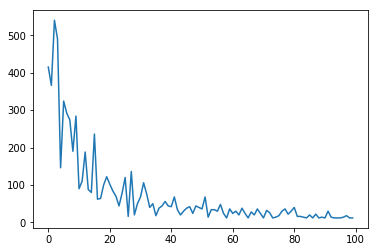

In [36]:
plt.plot(x, y)